
</br></br></br>
<font size="+10">제모옥은 데이타 분석으로 하겠습니다</font>
<font size="-1">근데 이제 모델을 곁들인</font>
</br></br></br>



### 이문제를 어떻게 접근해야 할지 고민해 보았습니다.
- 첫번째로 물류이동량에 직접적인 영향을 끼칠만한 이슈들에 대한 데이터가 아닌, 단순히 물류이동량의 통계 데이터만을 가지고 있었기에, 정확한 예측의 어려움이 있습니다.<br/>
(함축적인 데이터라고 생각했습니다. 물론, 세세한거까지 다 확인하는게 어렵습니다.)
- 두번째로 이번대회의 평가지표로 RMSE가 사용된다는것을 확인했습니다.
- 세번째로 1주에 대한 물류이동량을 시간대별로 예측한 결과물을 제출해야하는데,
학습시킬수있는데이터는 약 20주에 대한 데이터가 있습니다. 단순히 linear regression 문제로 접근한다면 쉽게 결과를 예측할수 있지만(예를 들어, 수열같은 경우), 첫번째와 같은 이유로 정확한 예측은 어렵다고 생각했습니다.


In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/USER/2_WEEK'

In [3]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
# df_test dataframe을 168까지만 읽어들인건, 이후의 데이터는 예측해야하는 값이기 때문입니다.
df1 = df_test[:168]

- df1 = df_test[:168] 에서 168이란 24*7이며,<br/>
24는 시간대를 의미하고, 7은 일주일을 의미합니다!


In [4]:
# 위에서 읽어들인 train data와 test data를 concat 하겠습니다.
df = pd.concat([df_train, df1])
df = df.reset_index(drop=True, inplace=False)
len(df)

3447

In [7]:
# data frame에 있는 도로이름들을 따로 모아서 리스트로 만들어보았습니다.
col_list = df.columns
col_list = col_list[2:]
col_list

Index(['10', '100', '101', '120', '121', '140', '150', '160', '200', '201',
       '251', '270', '300', '301', '351', '352', '370', '400', '450', '500',
       '550', '600', '650', '652', '1000', '1020', '1040', '1100', '1200',
       '1510', '2510', '3000', '4510', '5510', '6000'],
      dtype='object')

# EDA

### 각 도로별 물류이동량.
- 데이터는 2020년 1월 1일 0시부터 2020년 5월 24알 23시까지 확보한 상태입니다.<br/><br/>
- 도로별로 크게 2개의 봉우리가 나타나는것을 확인하실수 있습니다.<br/>(예외인 경우도 있습니다. 물류이동량이 명절과 연휴에 영향을 받지 않는다라고 생각하였습니다.)
  - 왼쪽부터 첫번째 봉우리는 2020년 설날연휴를 의미하며, 2번째 봉우리는 2020년 5월초의 황금연휴를 나타냅니다.
<br/><br/>
- 각 도로별 물류이동량에 대한 평균치가 매우 상이하다는것을 알 수 있습니다.
<br/><br/>
- 1100, 3000번과 같은 도로들은 주중에 물류이동량이 많았으며,<br/>600, 650번과 같은 도로들은 주말에 물류이동량이 많다는것을 알수있습니다.<br/>(이 부분에서 물류이동량이라는 단어보다 교통량이라는 단어가 더 어울리것같다는 생각을 했습니다. 앞으로는 교통량이라고 하겠습니다.)
<br/><br/>
- 아무래도 2020년 데이터이다 보니, 코로나와의 연관성을 비교해보았으며, 아래와 같은 생각을 하게 되었습니다.
  - 2020-01-24 ~ 2020-01-27 &nbsp;&nbsp;&nbsp;**설연휴** <br/>
  2020-02-23 ~ 2020-02-28 &nbsp;&nbsp;&nbsp;대구경북 거리두기 3단계 <br/>
  2020-02-28 ~ 2020-05-05 &nbsp;&nbsp;&nbsp;전국 거리두기 3단계<br/>
  2020-03-22 ~ 2020-04-07 &nbsp;&nbsp;&nbsp;강화된 거리두기(다인이용시설 통제)<br/>
  2020-04-08 ~ 2020-04-19 &nbsp;&nbsp;&nbsp;첫 집합금지 명령 <br/>
  2020-04-30 ~ 2020-05-05 &nbsp;&nbsp;&nbsp;**황금연휴**<br/>
  2020-05-06 ~ 2020-08-15 &nbsp;&nbsp;&nbsp;거리두기 1단계<br/>
  <br/><br/>
  - 1510, 3000, 301, 370, 400, 352번과 같은 도로들은 2020.3월을 기점으로 코로나와 관계있어보이는 변화량을 보여주었습니다.
  - 3000번 도로는 전국 거리두기 3단계를 기점으로 교통량이 확 줄었다가, 황금연휴에 급상승한 결과를 보실수도 있습니다.


<br/><br/><br/>
### train data에 대한 그래프 밑에 지난주와 지지난주에 대한 그래프를 보시면서, 최종결론을 얘기해 드리겠습니다.<br/>(여기서 말하는 지난주와 지지난주는 저희가 최종적으로 예측해야하는 target week를 기준으로 말씀드리는것입니다.)

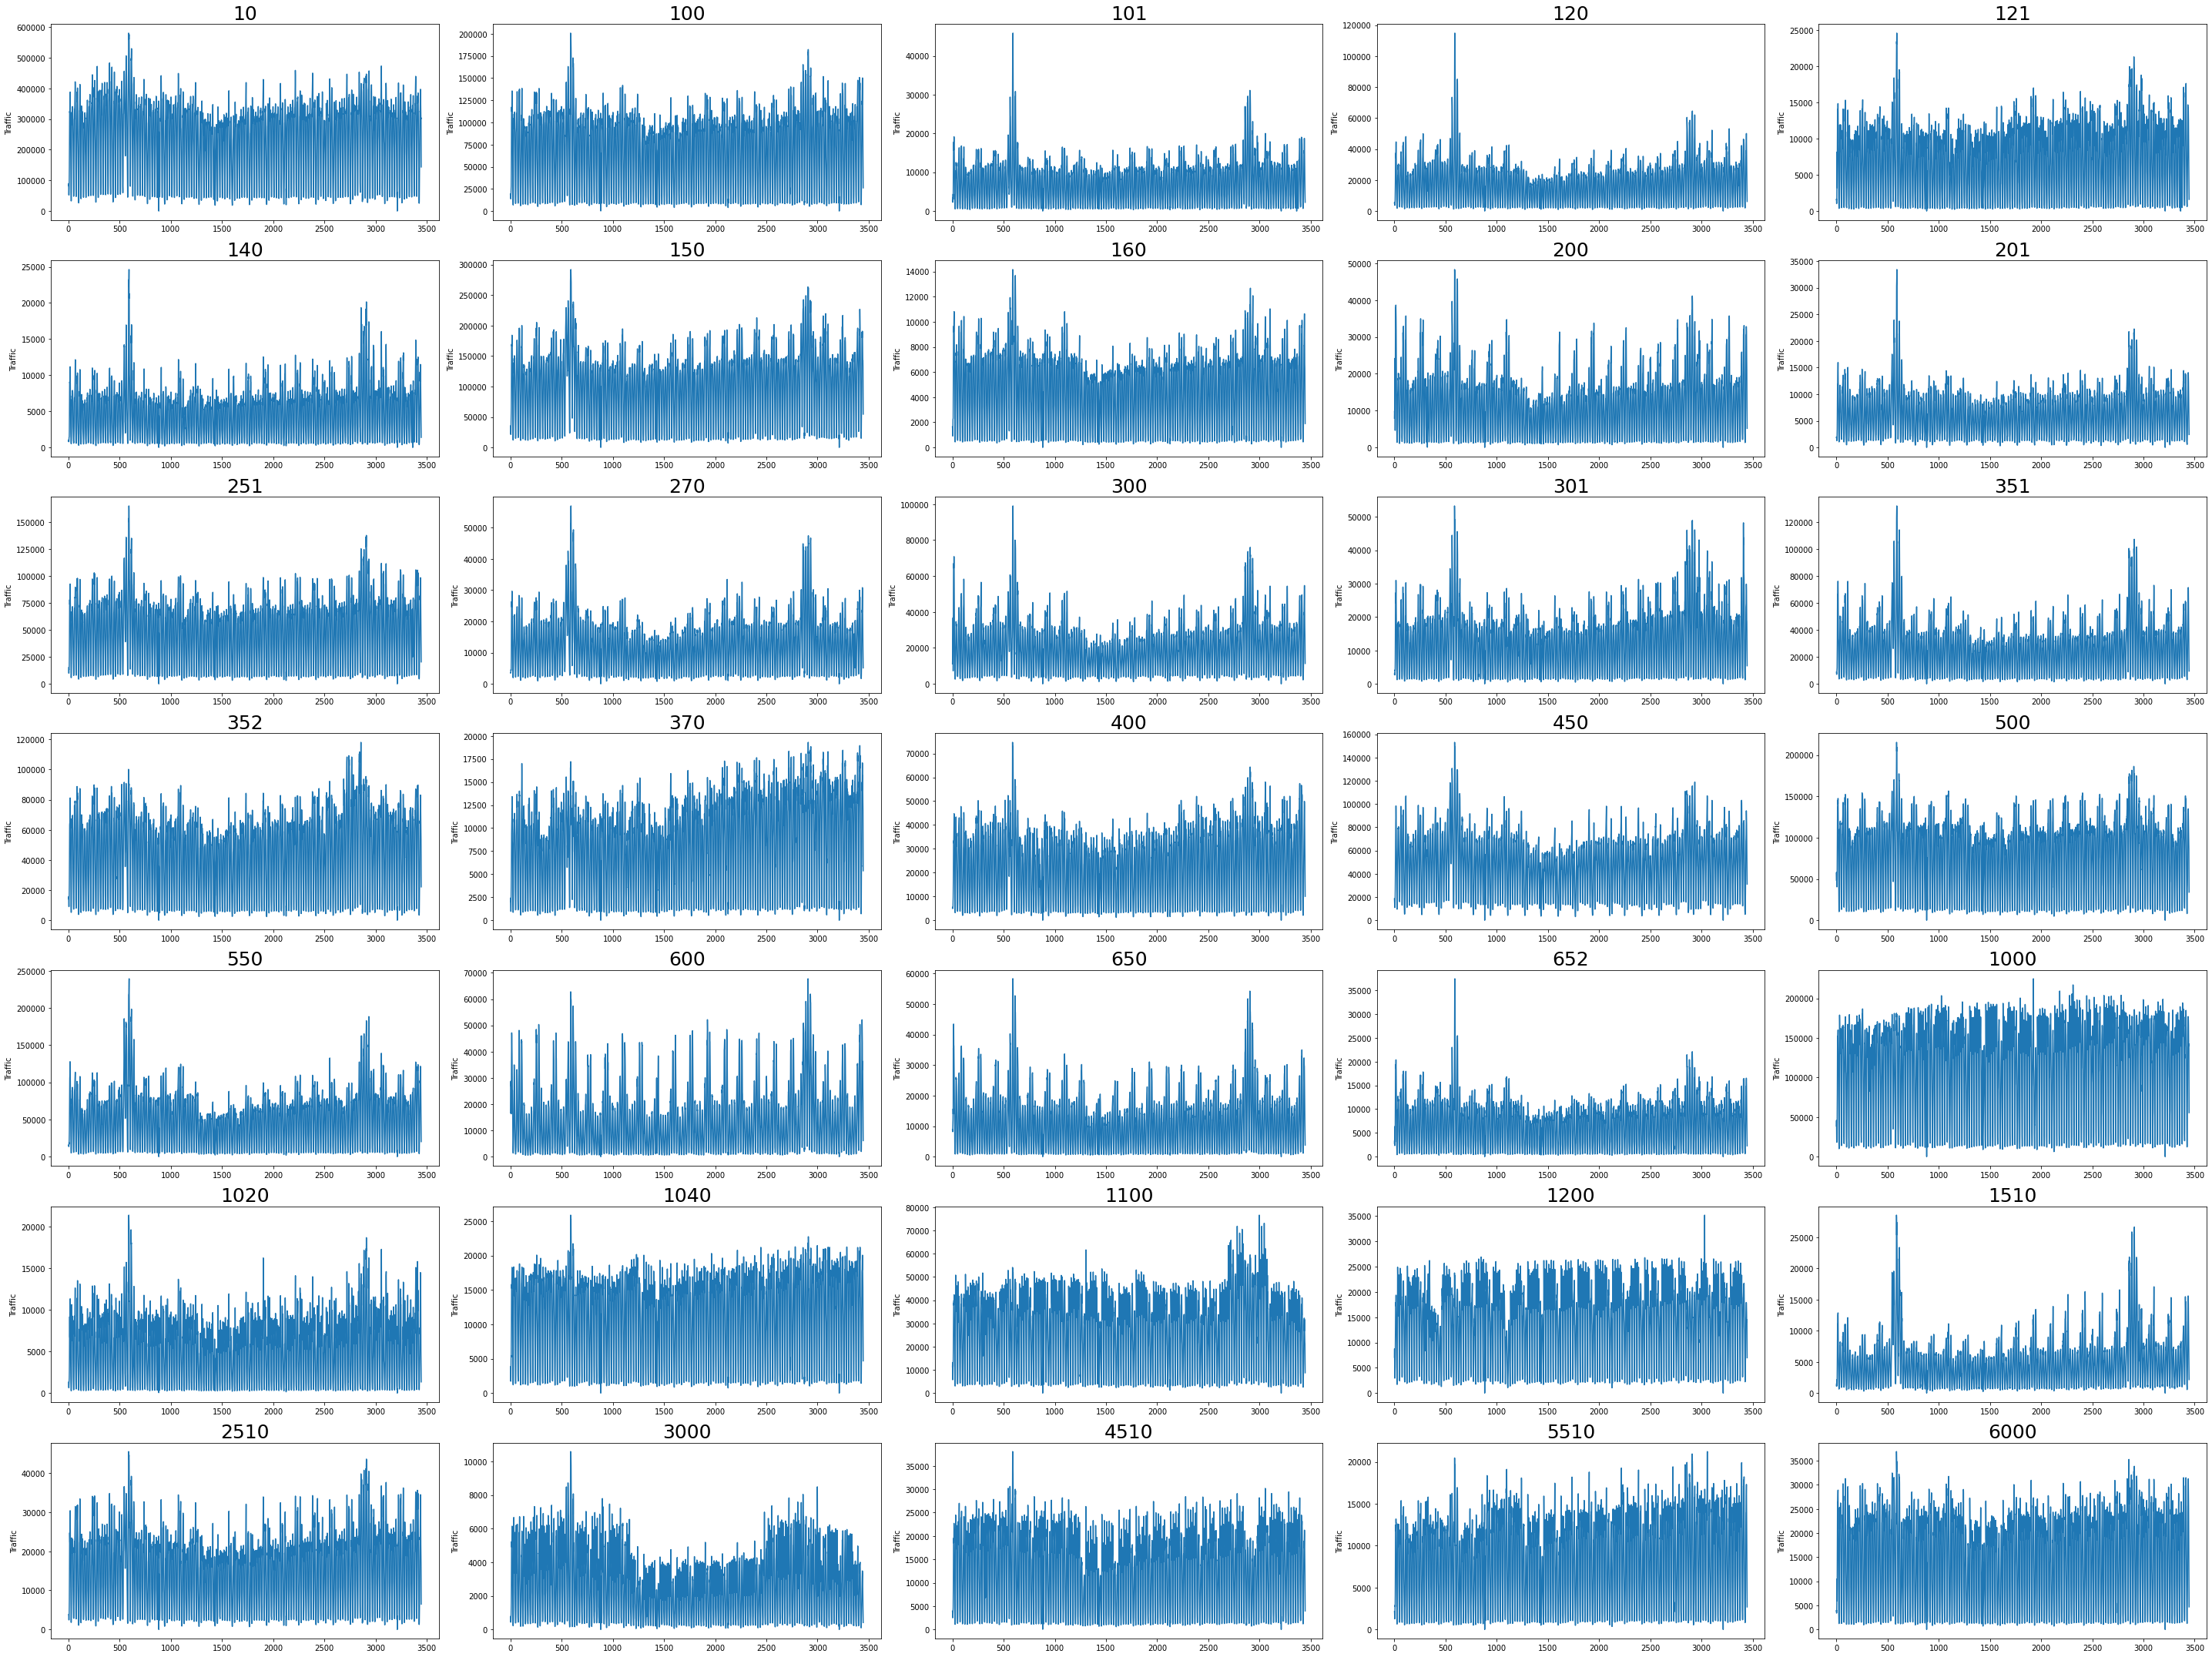

In [6]:
plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, col in enumerate(col_list, 1):
    plt.subplot(7, 5, i)
    df[col].plot()
    plt.ylabel('Traffic')
    plt.title(col, fontdict = {'fontsize' : 25})  
    
    
plt.tight_layout()

In [8]:
df1 = df_train[-168:]
df1 = df1.reset_index(drop=True, inplace=False)
df2 = df[-168:]
df2 = df2.reset_index(drop=True, inplace=False)

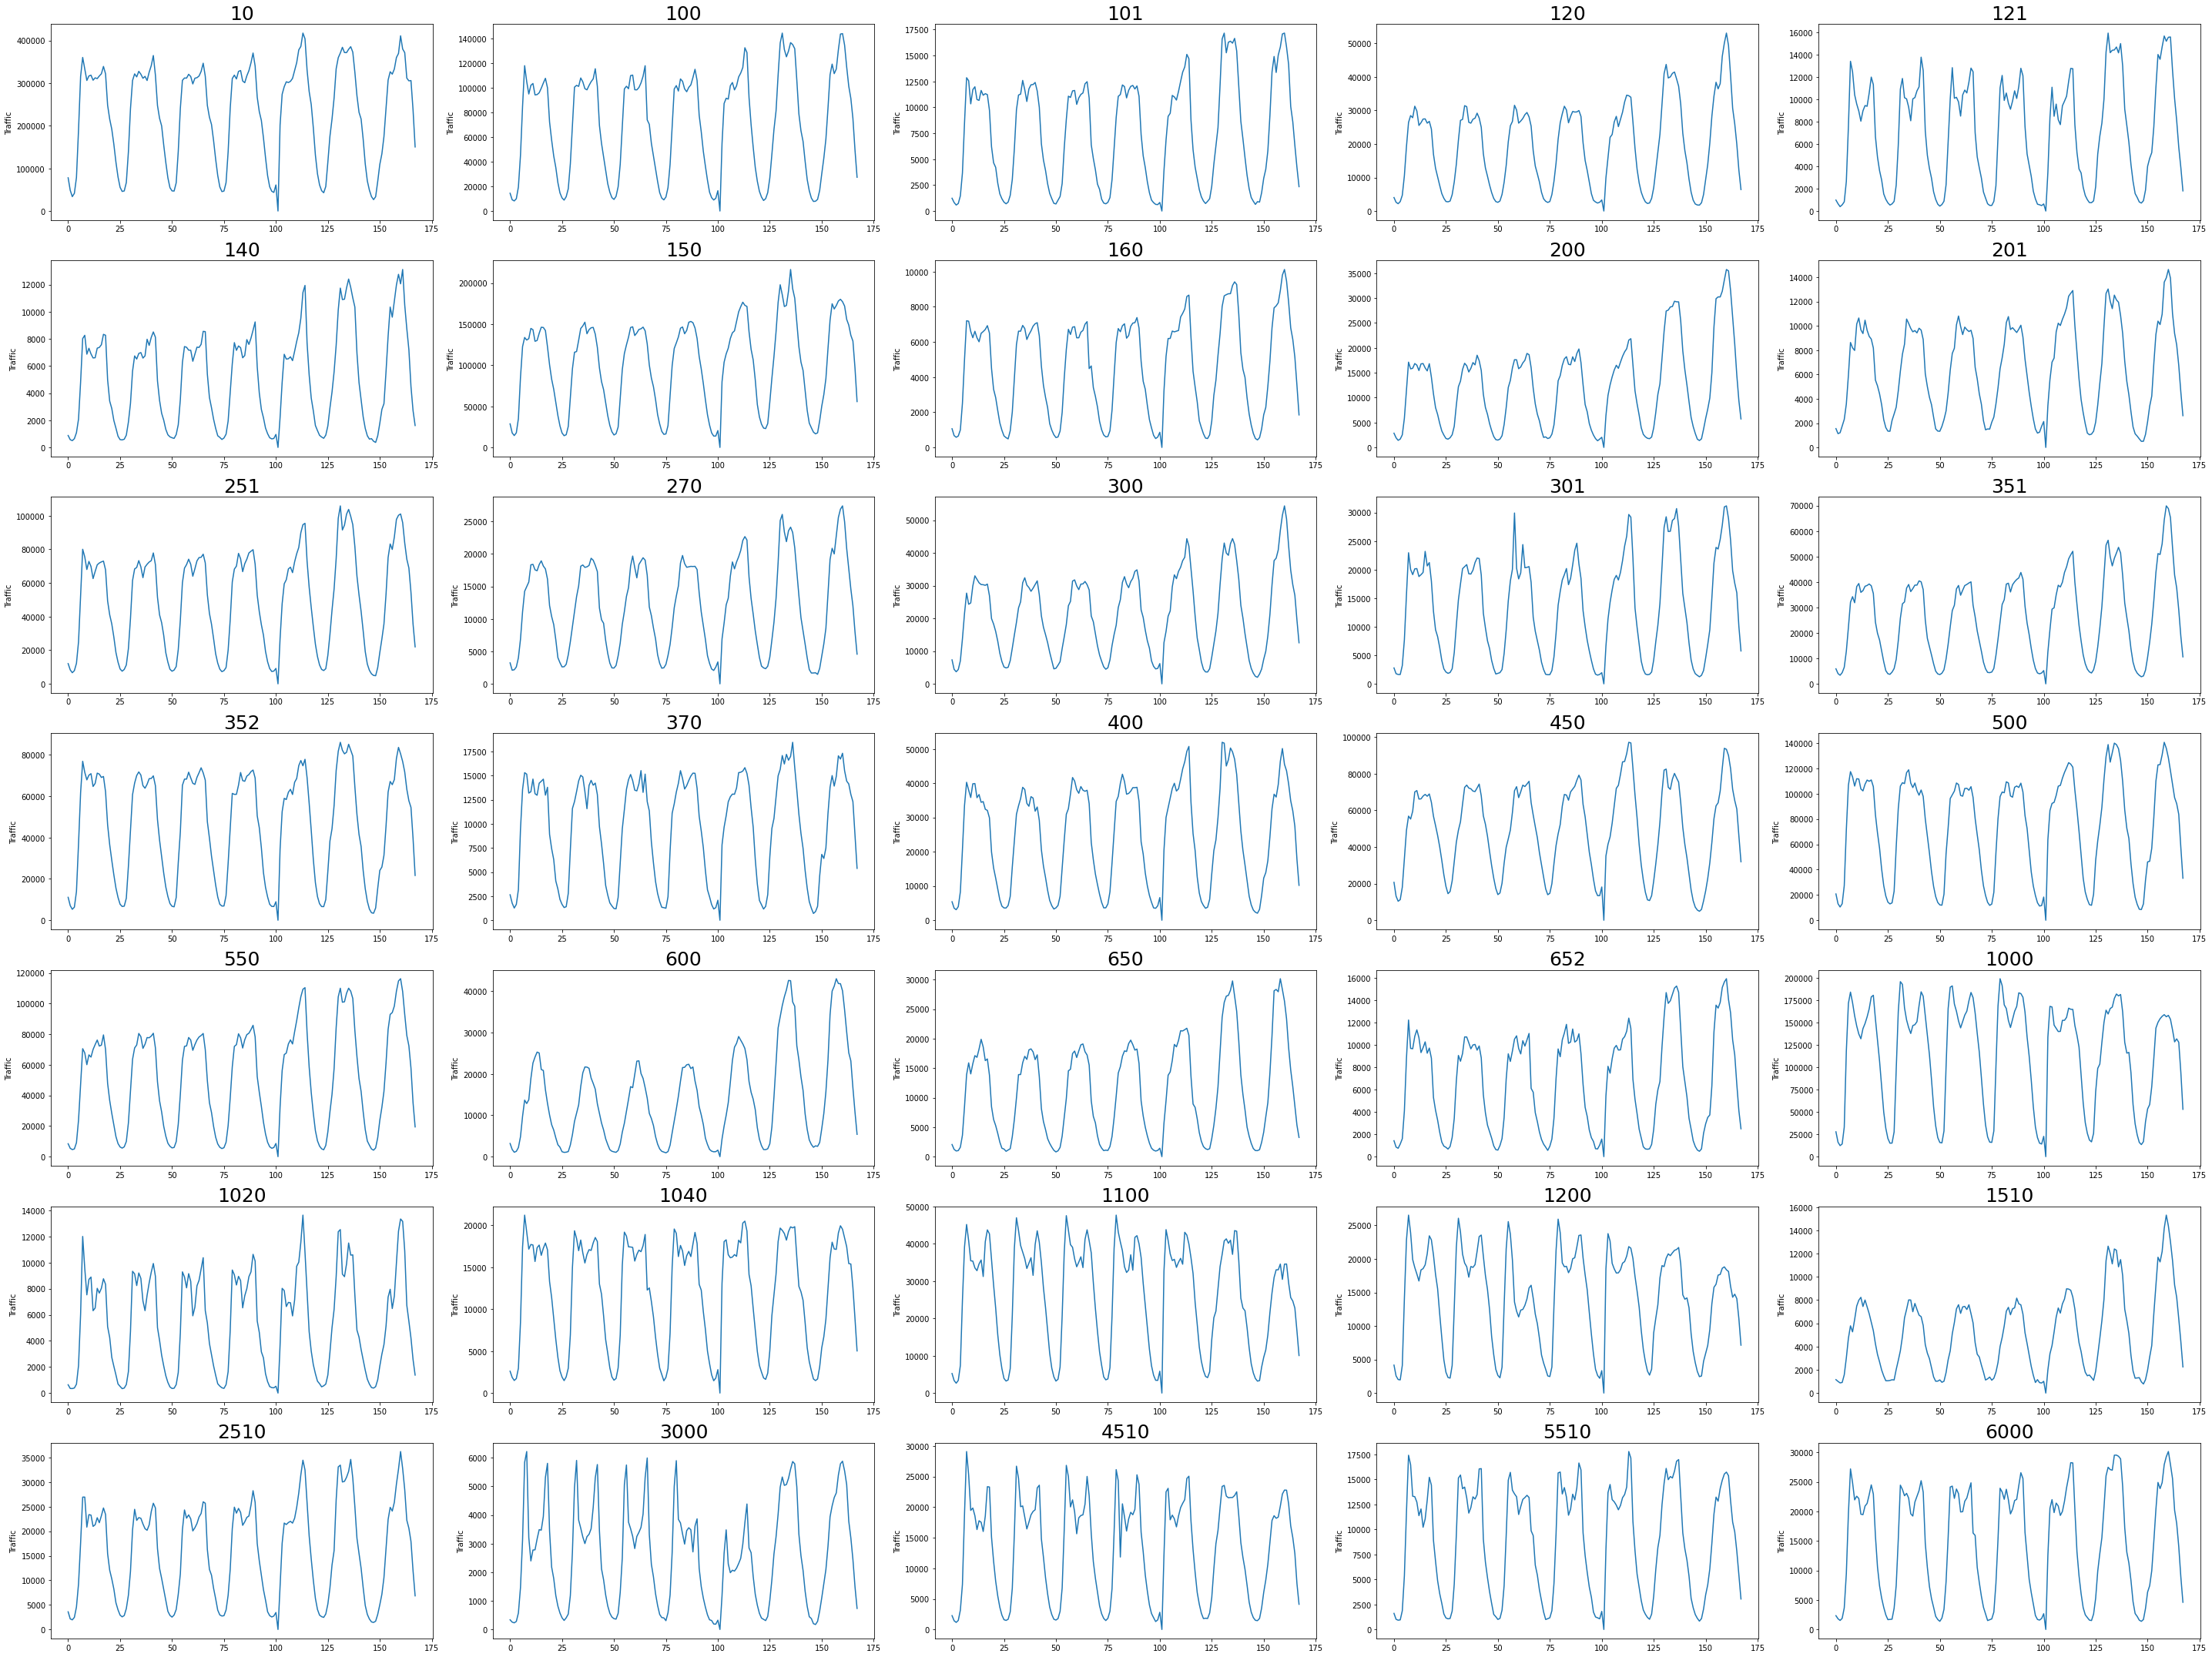

In [9]:
plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, col in enumerate(col_list, 1):
    plt.subplot(7, 5, i)
    df1[col].plot()
    plt.ylabel('Traffic')
    plt.title(col, fontdict = {'fontsize' : 25})

plt.tight_layout()

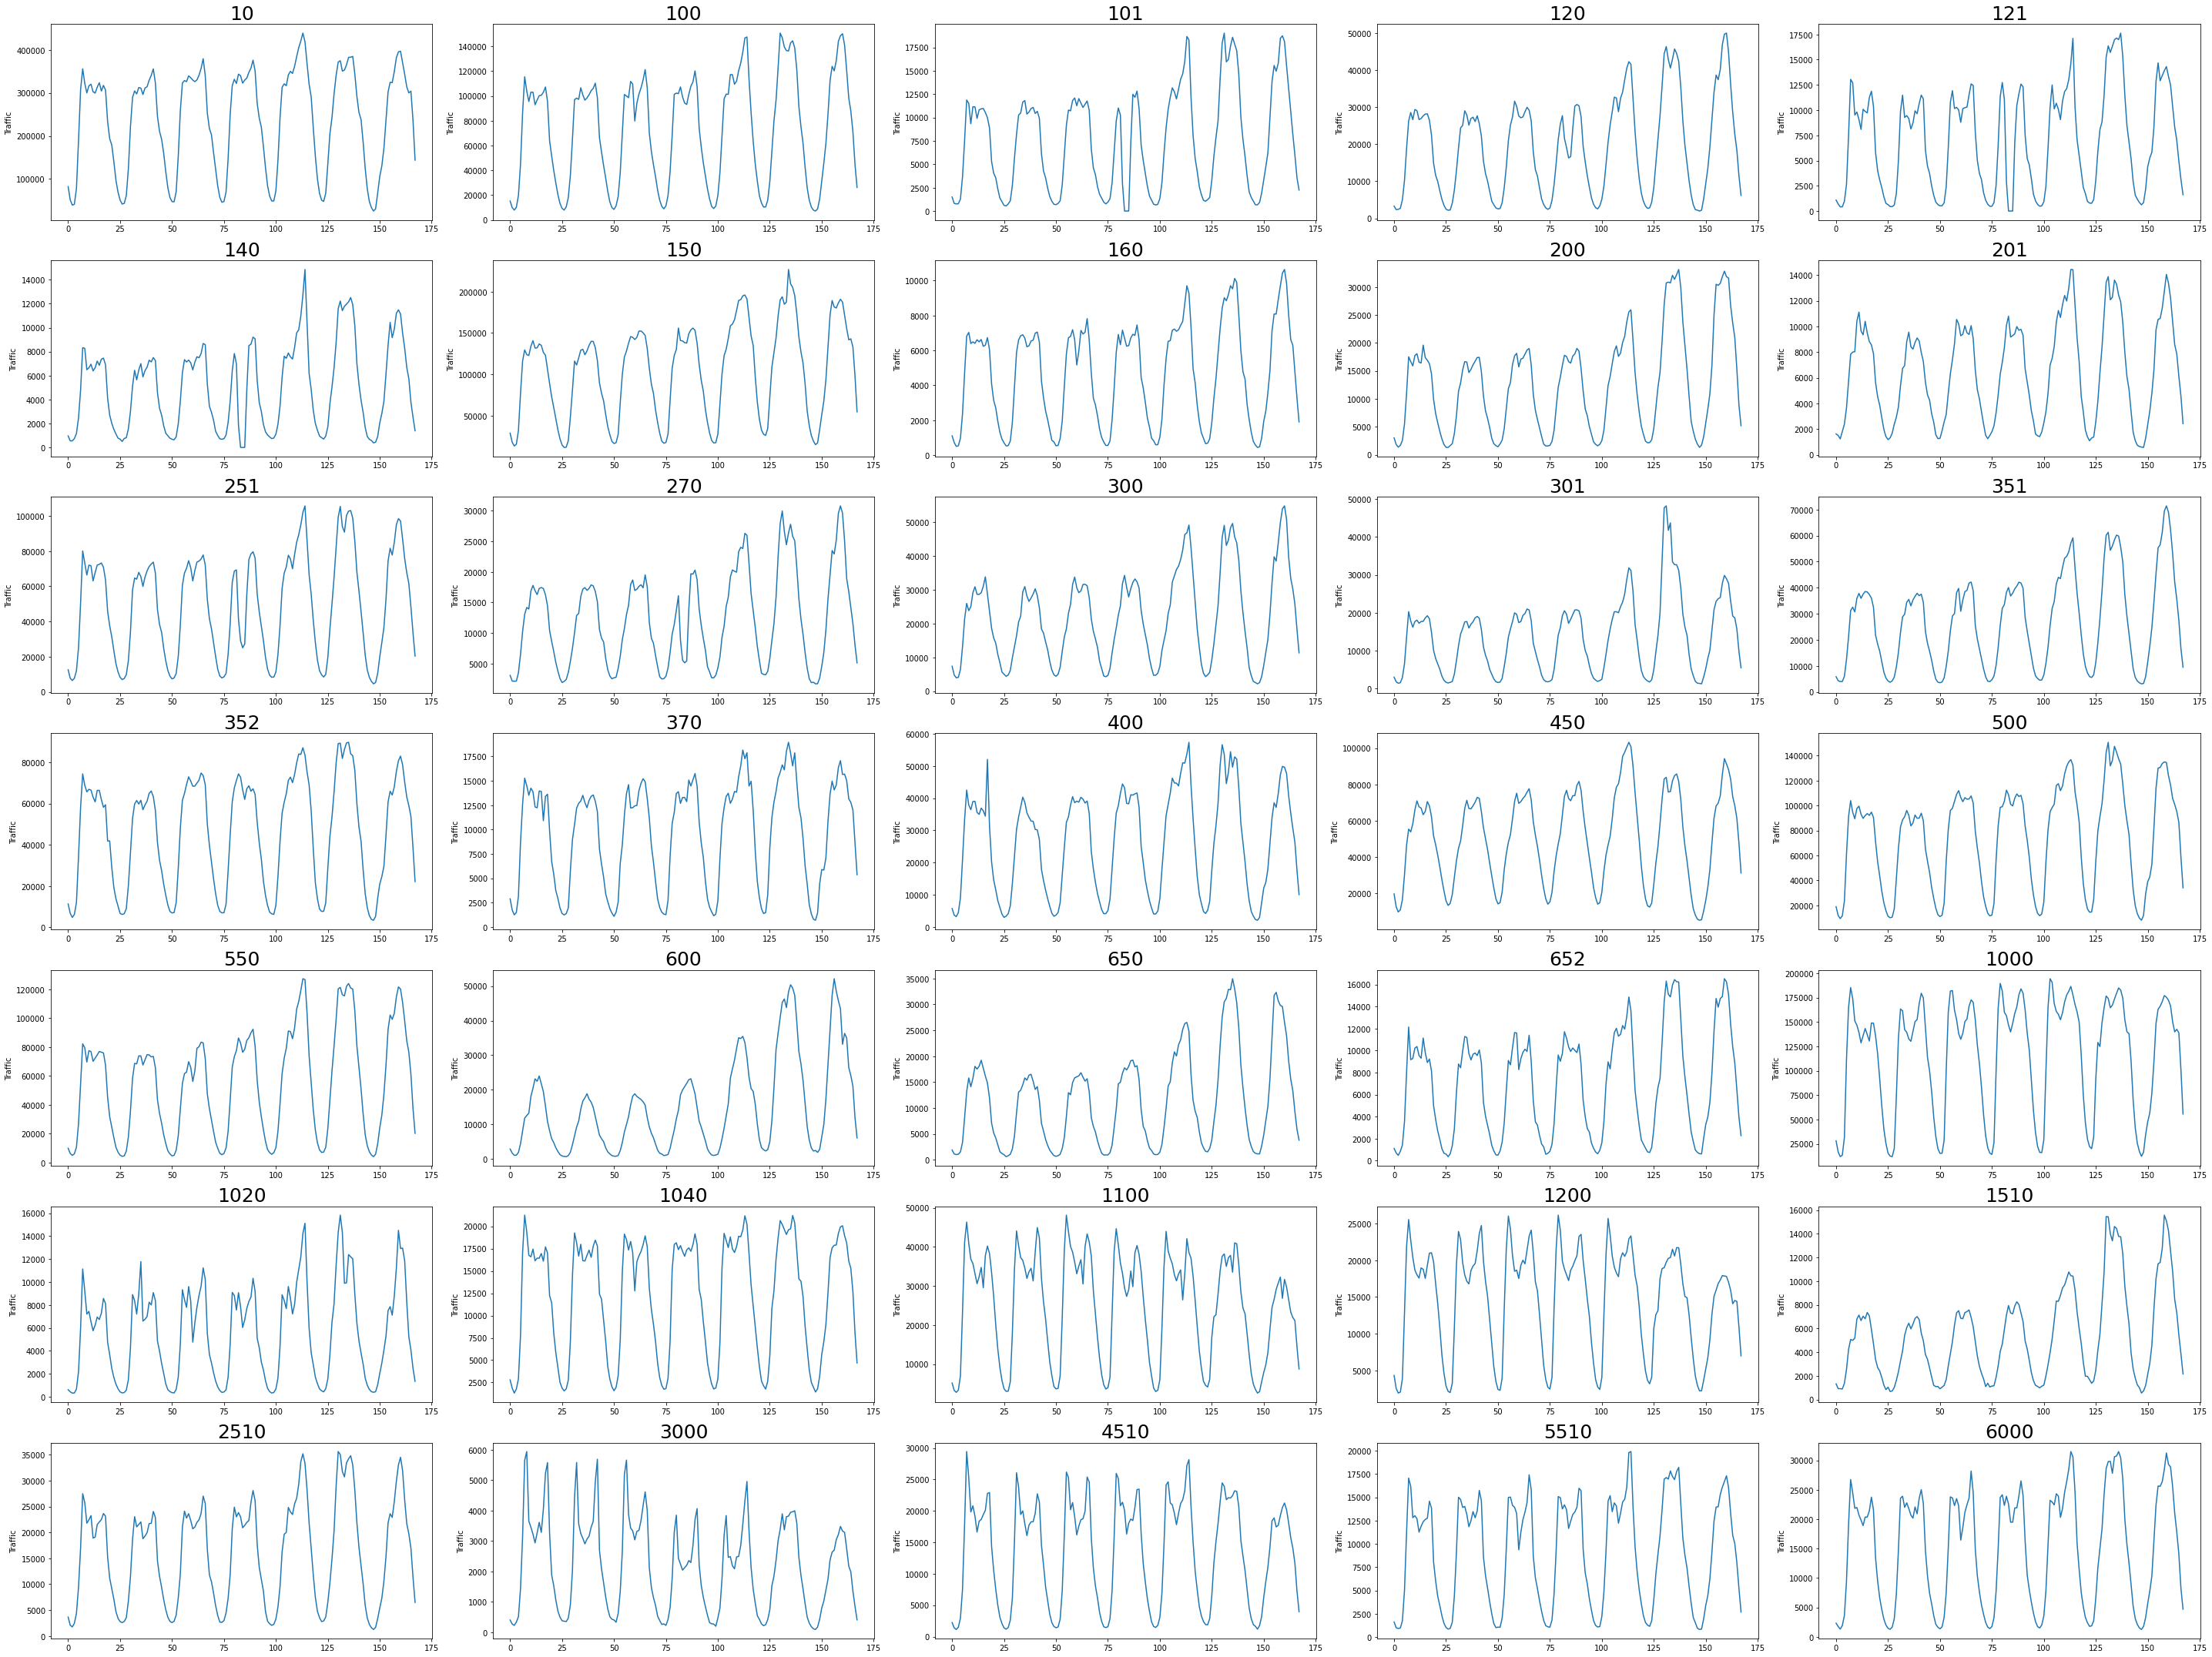

In [10]:
plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, col in enumerate(col_list, 1):
    plt.subplot(7, 5, i)
    df2[col].plot()
    plt.ylabel('Traffic')
    plt.title(col, fontdict = {'fontsize' : 25})

plt.tight_layout()

### 일주일만 분석해보았습니다.

- 여기서부터는 그래프만 보더라도 문제점들이 나타나기 시작합니다.
  - 첫번째로 데이터들이 0값을 가지는 경우가 종종 있습니다. (ex. 121, 101 등등)
  - 두번째로 0값은 아니지만 동일하고 연속된 값을 가지는 경우가 있습니다. (ex, 270, 251 등등)
  - 세번째로 곳곳에 튀는값들이 있지만, 제공받은 data들로만으로는 학습을 시키기가 어렵다고 생각했습니다.<br/>
  (어떤한 이유로 튀는값이 형성되었다라는 근거가 부족하다는 느낌을 받았습니다.<br/>예시를 들면,<br/>모델을 학습시켯을때, 모델의 예측결과가 튀는값으로 나왔고, 실제값도 튀는값이라고 한다면,예측이 맞아떨어진경우입니다.<br/>그런데, 교통량의 데이터만을 가지고 그러한 예측을 해서 결과를 맞추었다는게 이해가 가지 않았습니다.)



### EDA 결론:
- 경제,&nbsp;&nbsp;코로나,&nbsp;&nbsp;날씨,&nbsp;&nbsp;각 도로별 통행금지 등등 교통량과 밀접한 요소들은 많이 있지만, 저희는 교통량만을 가지고 교통량을 예측해야합니다.
- 또한, 같은 도로라고 할지라도 시간대별로 교통량이 매우 상이합니다.<br/>(튀는 값들도 포함해서요.)
- 마지막으로 밑에 이미지를 보시면, 4월27일부터 5월 24일까지의 시간대별 교통량을 trend로 본것입니다.

<br/><br/><br/>
## 저는 trend를 보고서 튀는값들에 굉장히 영향을 많이 받는다고 생각했습니다.
- 저희가 예측해야하는 1주의 데이터가 튀는값이 많을수도 있고, 적을수도 있는데,
모델이 이 부분을 예측해 줄수있을까? 어렵지 않을까? 하는 생각을 했습니다.


![image](https://cdn.discordapp.com/attachments/940518751974080532/944213205343940618/Screen_Shot_2022-02-18_at_9.46.06_PM.png)

In [11]:
# 데이터에대한 min-max 값 확인( RMSE값을 어떻게 하면 줄일수 있을가에 대한 고민.)
# min값으로 0값이 보인다..(이런 부분을 수정해주어야 할것으로 보인다.)
df.describe()

날짜           시간             10            100           101  \
count  3.447000e+03  3447.000000    3447.000000    3447.000000   3447.000000   
mean   2.020031e+07    11.472875  232021.168262   66991.016826   7160.330432   
std    1.384586e+02     6.925212  121832.588162   41786.472220   5568.256295   
min    2.020010e+07     0.000000       0.000000       0.000000      0.000000   
25%    2.020020e+07     5.000000  112123.000000   23554.500000   1898.500000   
50%    2.020031e+07    11.000000  267845.000000   74265.000000   6934.000000   
75%    2.020042e+07    17.000000  327604.500000  100138.500000  10918.000000   
max    2.020052e+07    23.000000  580098.000000  200808.000000  45869.000000   

                 120           121           140            150           160  \
count    3447.000000   3447.000000   3447.000000    3447.000000   3447.000000   
mean    17442.762402   6646.486510   4697.286336   99557.964317   4405.759501   
std     13326.993013   4795.946084   3538.158435   58404.831050   2858.852244   
min         0.000000      0.000000      0.000000       0.000000      0.000000   
25%      5222.000000   1700.000000   1312.500000   43252.000000   1534.000000   
50%     16681.000000   7008.000000   4712.000000  112017.000000   4772.000000   
75%     26118.000000  10332.000000   6964.000000  141126.000000   6671.000000   
max    114833.000000  24596.000000  24639.000000  292004.000000  14163.000000   

       ...          1020          1040          1100          1200  \
count  ...   3447.000000   3447.000000   3447.000000   3447.000000   
mean   ...   5168.441543  10974.525384  27063.472295  13961.833188   
std    ...   3886.411431   6194.492335  15518.485871   7124.215199   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...   1311.000000   4535.000000  11501.000000   7274.000000   
50%    ...   5167.000000  12921.000000  30836.000000  16013.000000   
75%    ...   8153.000000  16295.000000  38846.000000  19474.500000   
max    ...  21409.000000  25891.000000  76629.000000  35192.000000   

               1510          2510          3000          4510          5510  \
count   3447.000000   3447.000000   3447.000000   3447.000000   3447.000000   
mean    4895.391645  14698.942269   2449.119814  12171.445605   8004.364085   
std     4074.871094   9595.589258   1861.079709   8019.041923   5241.226791   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     1516.000000   4989.000000    713.500000   3620.000000   2558.000000   
50%     4261.000000  15933.000000   2198.000000  13631.000000   8625.000000   
75%     6801.000000  21828.000000   3727.000000  18798.000000  12561.000000   
max    28531.000000  45531.000000  10581.000000  38061.000000  21229.000000   

               6000  
count   3447.000000  
mean   14016.497534  
std     9303.941733  
min        0.000000  
25%     3976.500000  
50%    15221.000000  
75%    22114.000000  
max    36915.000000  

[8 rows x 37 columns]

In [12]:
# NaN값은 없습니다.
# df.isnull().sum()

In [13]:
# 코로나 이후의 데이터를 표현해주고있습니다.
df[1453:].head()

날짜  시간     10    100   101   120  121  140    150  160  ...  1020  \
1453  20200302   0  59436  10736   910  2347  750  514  20558  628  ...   526   
1454  20200302   1  39179   7737   562  1649  411  471  14273  477  ...   357   
1455  20200302   2  32681   6733   462  1566  264  449  11498  420  ...   259   
1456  20200302   3  38254   8835   587  1808  370  574  14131  456  ...   280   
1457  20200302   4  66913  17306  1133  3538  589  884  28211  923  ...   521   

      1040  1100  1200  1510  2510  3000  4510  5510  6000  
1453  1825  4620  3210   775  2516   192  1337  1162  1952  
1454  1204  2929  2059   731  1758   146   951   809  1221  
1455  1057  2515  1686   571  1541   157   723   617  1136  
1456  1300  3124  1769   849  2148   184  1116   839  1514  
1457  2687  7410  3439  1274  3610   361  1919  1689  2882  

[5 rows x 37 columns]

In [14]:
# 데이터 결측치를 표현해주고 있습니다.
df[882:883]

날짜  시간  10  100  101  120  121  140  150  160  ...  1020  1040  \
882  20200206  18   0   86    0    1    0    0    4    0  ...    49     0   

     1100  1200  1510  2510  3000  4510  5510  6000  
882     0     4     0     0     0    35     0     0  

[1 rows x 37 columns]

In [15]:
# 데이터 결측치를 표현해주고 있습니다.
df[3212:3213]

날짜  시간  10  100  101  120  121  140  150  160  ...  1020  1040  \
3212  20200515   5   0    0    0    0    0    0    0    0  ...     0     0   

      1100  1200  1510  2510  3000  4510  5510  6000  
3212     0     0     0     0     0     0     0     0  

[1 rows x 37 columns]

In [16]:
# 데이터 결측치를 표현해주고 있습니다.
df[3360:3367]

날짜  시간      10     100    101    120    121   140     150   160  \
3360  20200521   9  321981  101842  10269  27726  11048  6978  155996  6323   
3361  20200521  10  343667  107261   2942  21563   2881  1831  140808  7163   
3362  20200521  11  339887   99234      0  19127      0     0  140396  6696   
3363  20200521  12  322724   94243      0  16294      0     0  138321  6241   
3364  20200521  13  329873   93115      0  16674      0     0  137759  6276   
3365  20200521  14  334335  101138   7225  24275   6751  4802  149134  6716   
3366  20200521  15  347699  107829  12495  30297  10466  8501  153721  6923   

      ...  1020   1040   1100   1200  1510   2510  3000   4510   5510   6000  
3360  ...  7560  17388  35914  19875  5927  23000  2433  20816  13748  22349  
3361  ...  9071  17838  33240  18792  7137  23833  2246  21369  14187  23894  
3362  ...  7853  17197  29479  18025  7938  22988  2045  20082  13671  22567  
3363  ...  6034  16643  27321  17244  7317  20898  2125  16320  11651  19487  
3364  ...  6709  17356  29011  18653  7241  21368  2206  18046  12433  19496  
3365  ...  7698  17587  33825  19185  7900  21934  2359  18697  13151  21906  
3366  ...  8308  17205  29813  19964  8259  22285  2296  18462  13428  21927  

[7 rows x 37 columns]

In [17]:
## 데이터의 결측치라고 판단되는 값들을 처리하고 있습니다.

drop_index = list()

# 코로나 데이터 삭제
df = df[1453:]
df = df.reset_index(drop=True, inplace=False)

for index, row in df.iterrows():
  # 0값을 가지는 row들은 삭제하겠습니다.
  for col in col_list:
    if row[col] == 0:
      drop_index.append(index)
      break

# vacations = [20200124, 20200125, 20200126, 20200127, 20200430, 20200501, 20200502, 20200503, 20200504, 20200505]
vacations = [20200123, 20200124, 20200125, 20200126, 20200127, 20200128, 20200429, 20200430, 20200501, 20200502, 20200503, 20200504, 20200505, 20200506]
for index, row in df.iterrows():
  # 설날연휴와 황금연휴는 삭제하겠습니다.
  if row["날짜"] in vacations:
    drop_index.append(index)
  

# print(drop_index)
df = df.drop(drop_index)
df = df.reset_index(drop=True, inplace=False)
len(df)

1798

In [30]:
# 중복된 인덱스가 없다는것을 확인했습니다.
# from collections import Counter
# c = Counter(drop_index)
# c

In [18]:
df.describe()

날짜           시간             10            100           101  \
count  1.798000e+03  1798.000000    1798.000000    1798.000000   1798.000000   
mean   2.020040e+07    11.490545  224486.565628   65763.626808   6899.966073   
std    7.777003e+01     6.935883  115607.180963   40200.863520   4886.841042   
min    2.020030e+07     0.000000   18729.000000    3927.000000    313.000000   
25%    2.020032e+07     5.000000  110455.750000   22718.500000   1873.750000   
50%    2.020041e+07    11.000000  265069.500000   74862.000000   7014.000000   
75%    2.020043e+07    17.750000  318807.000000   98883.500000  10866.750000   
max    2.020052e+07    23.000000  472649.000000  151778.000000  19999.000000   

                120           121           140            150           160  \
count   1798.000000   1798.000000   1798.000000    1798.000000   1798.000000   
mean   16440.104004   6742.968298   4663.933259   98898.330923   4202.643493   
std    11343.305765   4725.480693   3276.995859   56436.608376   2652.627176   
min      937.000000    263.000000    223.000000    7095.000000    252.000000   
25%     5049.250000   1776.000000   1323.000000   43011.500000   1473.250000   
50%    16790.500000   7255.000000   4960.000000  114629.500000   4612.500000   
75%    25189.750000  10563.000000   7007.750000  142047.000000   6418.000000   
max    53098.000000  17634.000000  16051.000000  226740.000000  11032.000000   

       ...          1020          1040          1100          1200  \
count  ...   1798.000000   1798.000000   1798.000000   1798.000000   
mean   ...   4995.240823  11111.213571  26389.729700  14455.950501   
std    ...   3639.813092   6262.657655  15313.534541   7245.504916   
min    ...    149.000000    746.000000   1220.000000   1040.000000   
25%    ...   1305.500000   4555.250000  10576.500000   7896.000000   
50%    ...   5154.500000  13213.000000  30428.000000  16977.500000   
75%    ...   8002.250000  16524.500000  37749.000000  19946.000000   
max    ...  17293.000000  21281.000000  73117.000000  35192.000000   

               1510         2510         3000          4510          5510  \
count   1798.000000   1798.00000  1798.000000   1798.000000   1798.000000   
mean    4716.375973  14319.03337  2190.780868  11994.189655   8245.850945   
std     3457.057350   9085.39292  1611.584775   7792.023717   5300.390322   
min      326.000000    701.00000    61.000000    581.000000    358.000000   
25%     1525.000000   5021.50000   629.250000   3587.500000   2648.000000   
50%     4275.500000  15990.50000  2130.000000  13810.500000   8907.000000   
75%     6811.750000  21292.75000  3354.000000  18257.250000  12864.000000   
max    17046.000000  37632.00000  7824.000000  30182.000000  21229.000000   

               6000  
count   1798.000000  
mean   13890.589544  
std     9101.865943  
min      685.000000  
25%     3875.750000  
50%    15346.000000  
75%    21921.750000  
max    31504.000000  

[8 rows x 37 columns]

### 데이터셋 재정의
- EDA를 통하여 요일별 시간별로 따로따로 예측을 해주면 되겠다라고 생각을합니다.
- 최종결과물은 168 * 35의 형태를 가지고 있습니다.<br/>
여기서 168이란 24 * 7 이며,<br/> 24는 시간대를 의미하고, 7은 월화수목금토일(요일)을 의미합니다.<br/>
35는 도로의 갯수입니다.
- 1월1일부터 5월 24일까지 각 도로에 대한 월요일 0시 데이터들을 모으고, 1시데이터를 모으고,<br/>
그렇게 계속해서 일요일 23시 데이터까지 모읍니다.<br/>(저는 아래와 같은 형태를 고려했습니다.)
```python
Monday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Tuesday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Wednesday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Thursday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Friday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Saturday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Sunday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
```
이렇게 되면 linear regression만으로도 문제를 해결할수있습니다.<br/>
하지만, 제가 EDA에서 말씀드린대로 튀는값에 대해서는 대처가 불가능하다고 생각했습니다.<br/>
그리하여 RMSE를 이용하자고 생각했습니다.<br/><br/><br/><br/>


In [20]:

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

Monday = dict()
Tuesday = dict()
Wednesday = dict()
Thursday = dict()
Friday = dict()
Saturday = dict()
Sunday = dict()

for col in col_list:
  Monday[col] = dict()
  Tuesday[col] = dict()
  Wednesday[col] = dict()
  Thursday[col] = dict()
  Friday[col] = dict()
  Saturday[col] = dict()
  Sunday[col] = dict()
  for i in range(24):
    Monday[col][i] = list()
    Tuesday[col][i] = list()
    Wednesday[col][i] = list()
    Thursday[col][i] = list()
    Friday[col][i] = list()
    Saturday[col][i] = list()
    Sunday[col][i] = list()



for i in range(len(df)):
  year = str(df["날짜"][i])[:4]
  month = str(df["날짜"][i])[4:6]
  day = str(df["날짜"][i])[6:]
  b = days[datetime.date(int(year), int(month),int(day)).weekday()]
  # print(b, df.시간[i], df["100"][i], df.loc[i][2])

  for idx, col in enumerate(col_list):
    # print(df.loc[i][idx+2])
    if b == "Monday":
      Monday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Tuesday":
      Tuesday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Wednesday":
      Wednesday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Thursday":
      Thursday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Friday":
      Friday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Saturday":
      Saturday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Sunday":
      Sunday[col][df.시간[i]].append(df.loc[i][idx+2])
        


In [100]:
df_mon = pd.DataFrame(Monday)
df_fri = pd.DataFrame(Friday)

### 아래의 그래프를 보시면 시간에 따른 관계가 있는것처럼 보이시나요?

---




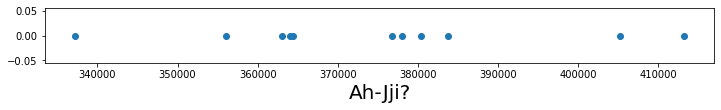

In [102]:
# x = Wednesday["10"][0]
# x = Monday["10"][15]
x = Friday["10"][15]

y = [0 for val in x]
fig, ax = plt.subplots()
fig.set_size_inches(12,1)
ax.set_xlabel("Ah-Jji?", fontsize=20)
plt.scatter(x,y)


In [103]:
# index = [[0,1,2,3,4,5], [6,7,8,9,10,11], [12,13,14,15,16,17], [18,19,20,21,22,23]]


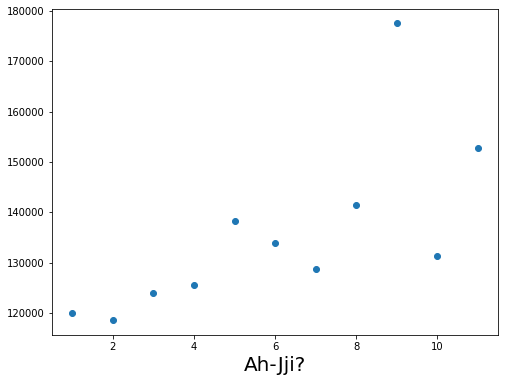

In [113]:


y = [val+1 for val in range(len(x))]
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.set_xlabel("Ah-Jji?", fontsize=20)
plt.scatter(y,x)


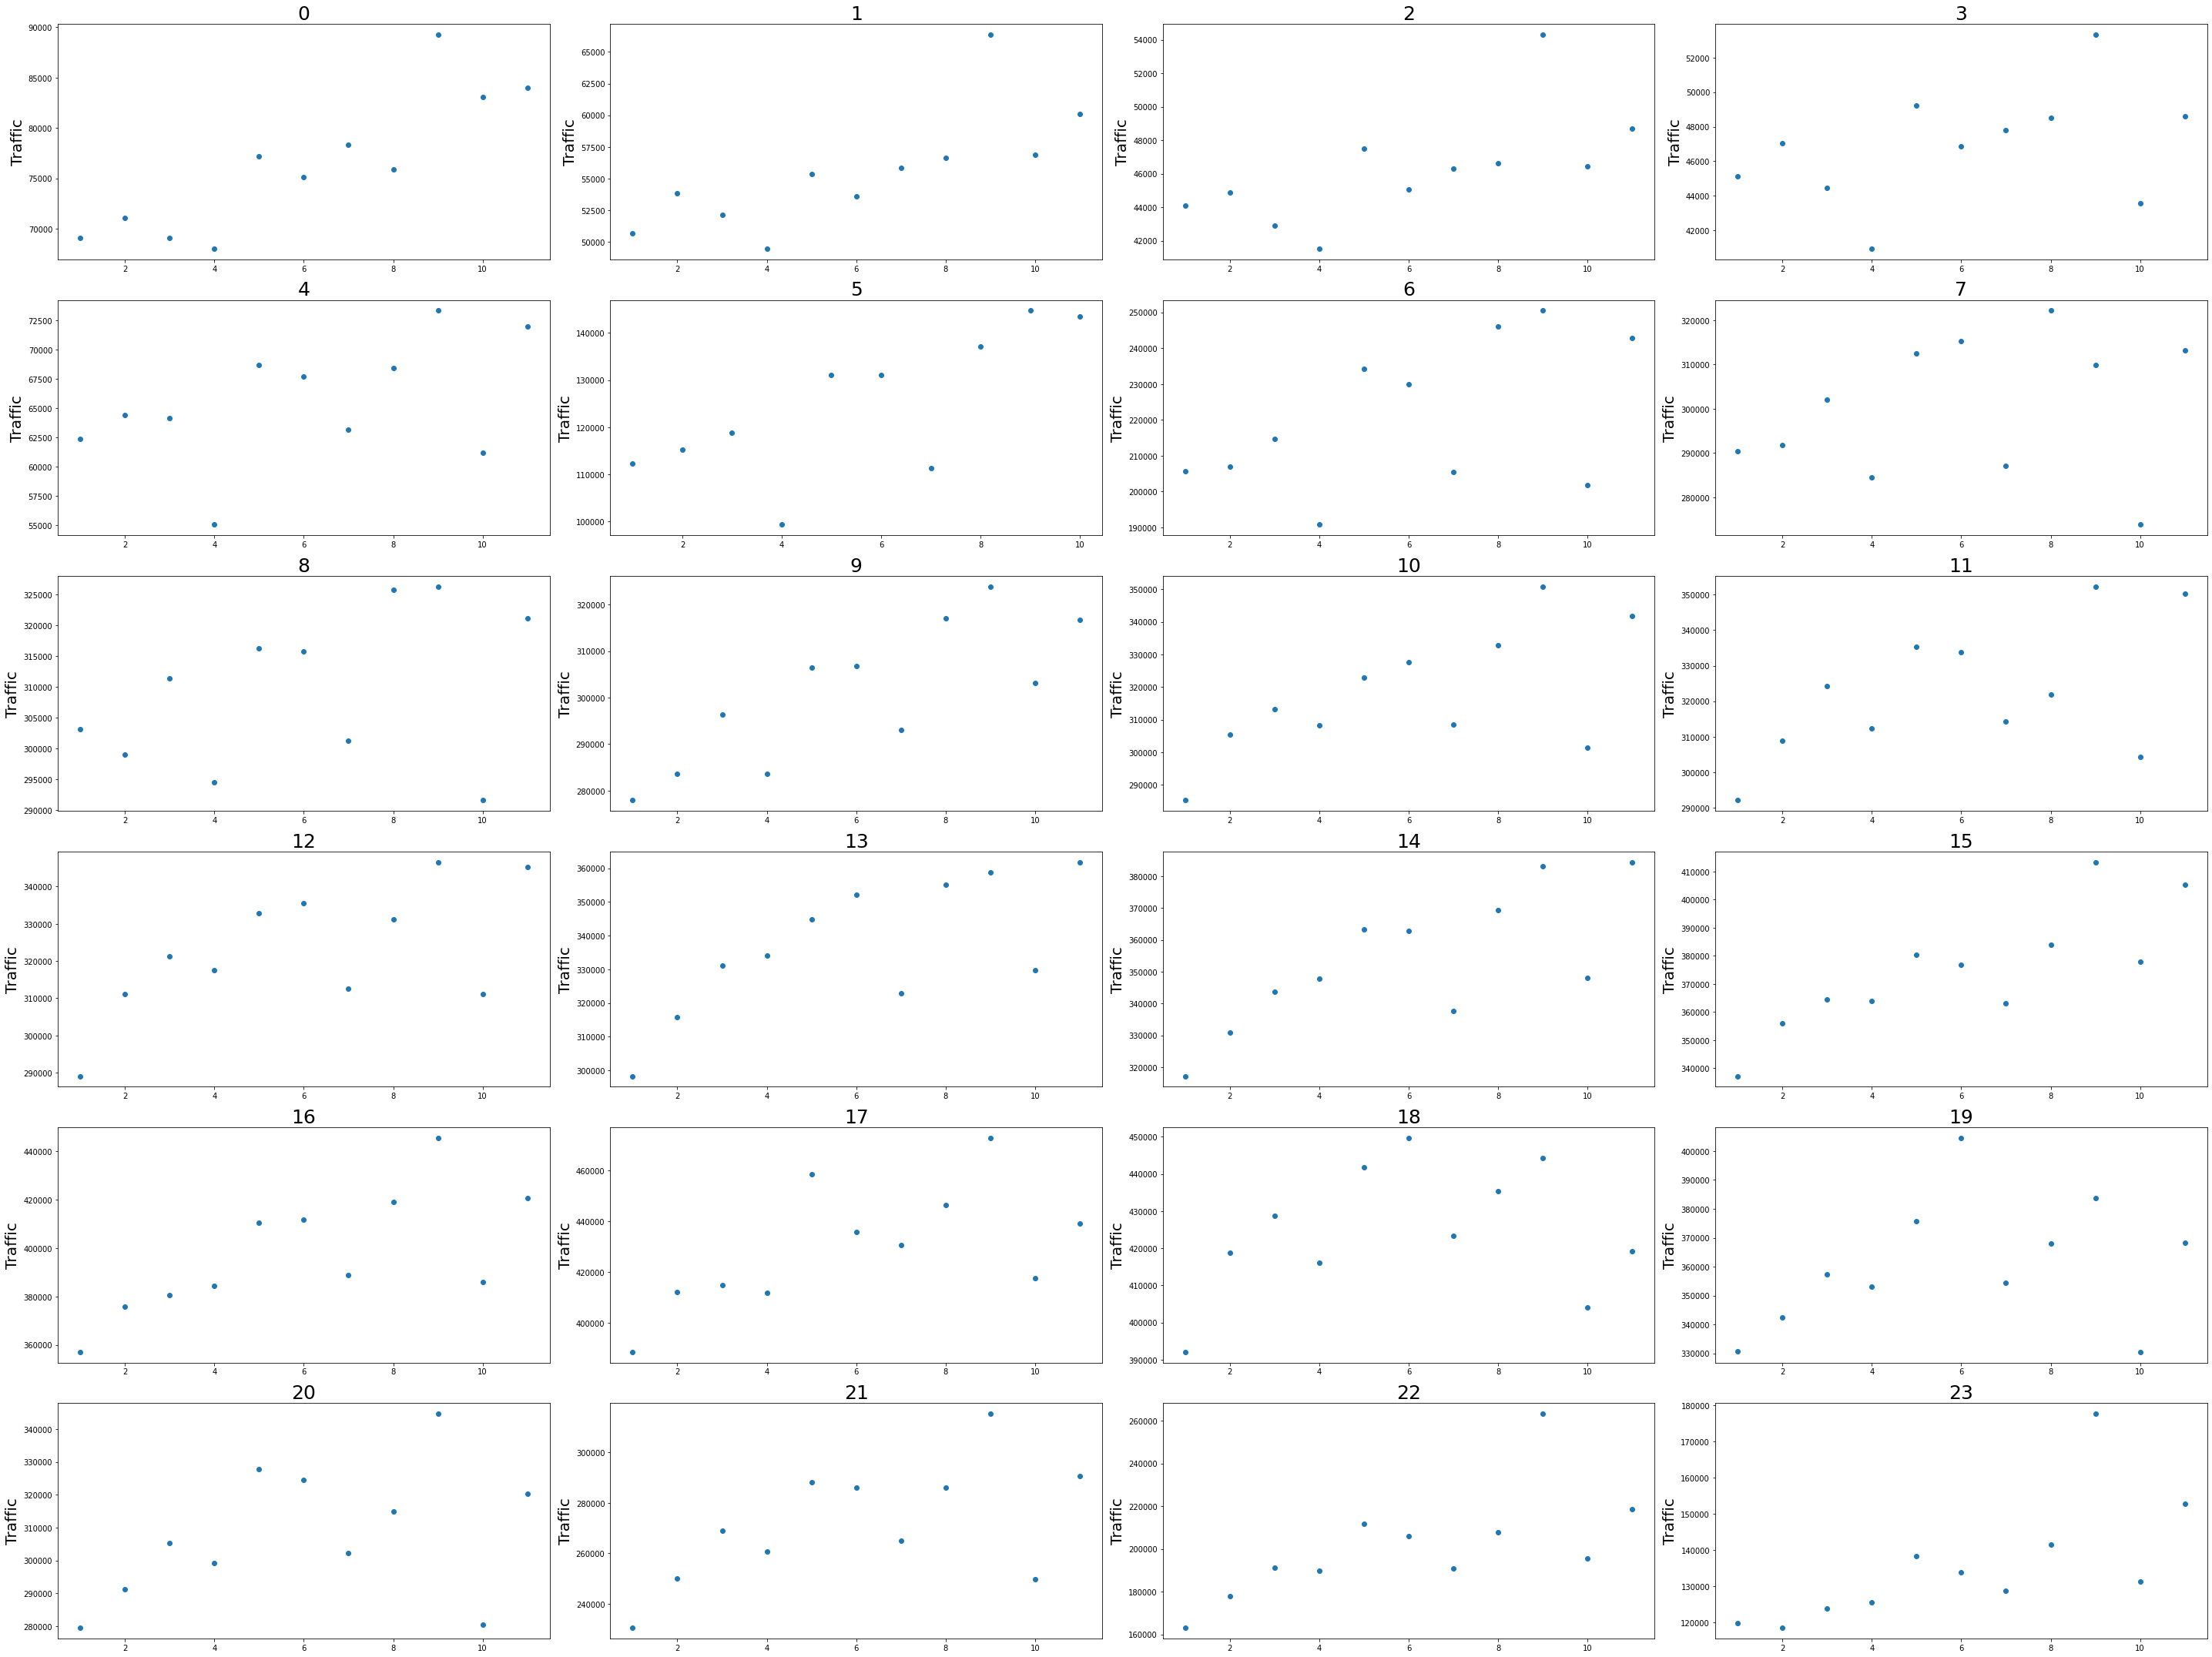

In [114]:
# fig = plt.figure(figsize=(40,30))
# fig, axes= plt.subplots(4,6) # axes는 Axes객체의 2x2의 배열
# for i in range(4):
#     for j in range(6):
#         plt.subplot(4, 6, i+1)
#         x = df_mon["10"][index[i][j]]
#         axes[i][j].plot(x)
        
        
#         plt.subplot(6, 4, i+1)
#         df_temp = pd.DataFrame(x)
#         df_temp.plot()
        # plt.ylabel('Traffic')
        # plt.xlabel('Time')
        # plt.title(i, fontdict = {'fontsize' : 25})
    
    

plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i in range(24):
    x = df_fri["10"][i]
    y = [val+1 for val in range(len(x))]
    plt.subplot(6, 4, i+1)
    fig.set_size_inches(8,6)
    plt.scatter(y,x)
    plt.ylabel('Traffic', fontsize=20)
    ax.set_xlabel("Time", fontsize=20)
    plt.title(i, fontdict = {'fontsize' : 25})
    
    

plt.tight_layout()


### 정확하게 튀는값을 맞추려고 하지말고, 안전하게 무난한값을 선택하면 되지 않을까?
#### 증가하는 추세를 유지하면서, 그럴싸한 값을 제출하면 되지 않을까?
위와 같은 생각을 하게 되고, 시험삼아 지난주와 지지난주의 데이터의 평균값을 대입해서 
제출해본 결과, 훌륭한 점수를 얻어낼수 있었습니다.<br/>


---


public 3620점, private 3623점을 기록하였습니다.<br/>
지난2주의 데이터의 평균을 구하는데,지난주 데이터에 5%의 가중치를 더해주고, 지지난주 데이터에 2.5%의 가중치를 뺴줌으로써 나온 결과입니다.
![image](https://github.com/NOTITLEUNTITLE/MNC_traffic/blob/main/image1.PNG?raw=true)

<br/><br/><br/>



---


최종적으로는 public점수가 3500점이 나온걸 택했지만, private 점수가 3790이 나왔습니다.<br/>
지난 3주의 데이터를 평균을 구하는데, 지난주 데이터에 5%의 가중치를 더해준 결과를 제출하였을때의 점수였습니다.<br/>
위로 미루어 보아, 위에서 보여드린 그래프에서도 알수있었듯이, **아마도 대다수의 도로들이 증가하는 추세**를 보이고 있다고 생각됩니다.








![image](https://github.com/NOTITLEUNTITLE/MNC_traffic/blob/main/image3.PNG?raw=true)



### 여기까지가 이번대회에서 고민한 내용들입니다.
- 첫번째로 아쉬운점은, linear regression 모델을 구현해서, 모델의 예측값을 확인해보려했으나, 대회종료 4분전임을 알았으며, 시도하지 못했습니다..
- 두번재로 아쉬운점은, 각 도로별로 11-12개의 데이터들의 증가세와 감소세를 코딩으로 확인해 보려했으나, 대회종료 3분전임을 알았으며, 시도하지 못했습니다..<br/>
  - 11-12개 정도되는 데이터를 시간순서대로 증가했는지, 감소했는지 확인한후,<br/>과반이상이 증가했다면 가중치를 더해주고,<br/>과반이상이 감소했다면 빼주는 방법을 생각했습니다.<br/> 도로별로 교통량이 상이하기에 volume도 고려해야합니다.(단순히 증가했다, 감소했다가 아니라 증가량,감소량이 중요합니다.)<br/>
아니면, 끝에 데이터 2-3개만 해보는것도 정확할 것 같습니다.



### linear regression
- Linear regression 참고 사이트
- <a href="https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#simple-linear-regression-basics" taget="_blank">https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#simple-linear-regression-basics</a>

### 파일 제출

In [ ]:
Mon_result = list()
Tues_result = list()
Wednes_result = list()
Thurs_result = list()
Fri_result = list()
Satur_result = list()
Sun_result = list()



for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Monday[col][i][-3:]) + (Monday[col][i][-1] * 0.05) ) / len(Monday[col][i][-3:]), 1)
    temp.append(value)
  Mon_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Tuesday[col][i][-3:]) + (Tuesday[col][i][-1] * 0.05) ) / len(Tuesday[col][i][-3:]), 1)
    temp.append(value)
  Tues_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Wednesday[col][i][-3:]) + (Wednesday[col][i][-1] * 0.05) ) / len(Wednesday[col][i][-3:]), 1)
    temp.append(value)
  Wednes_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Thursday[col][i][-3:]) + (Thursday[col][i][-1] * 0.05) ) / len(Thursday[col][i][-3:]), 1)
    temp.append(value)
  Thurs_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Friday[col][i][-3:]) + (Friday[col][i][-1] * 0.05) ) / len(Friday[col][i][-3:]), 1)
    temp.append(value)
  Fri_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Saturday[col][i][-3:]) + (Saturday[col][i][-1] * 0.05) ) / len(Saturday[col][i][-3:]), 1)
    temp.append(value)
  Satur_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Sunday[col][i][-3:]) + (Sunday[col][i][-1] * 0.05) ) / len(Sunday[col][i][-3:]), 1)
    temp.append(value)
  Sun_result.append(temp)

In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/PyTorch_YearDream/2022-02-17/data/sample_submission.csv")

In [ ]:
pivot = 24

for i, col in enumerate(col_list):
  submit[col][:pivot] = Mon_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot:pivot*2] = Tues_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*2:pivot*3] = Wednes_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*3:pivot*4] = Thurs_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*4:pivot*5] = Fri_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*5:pivot*6] = Satur_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*6:] = Sun_result[i]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lo

In [ ]:
submit.describe()

10            100  ...          5510          6000
count     168.000000     168.000000  ...    168.000000    168.000000
mean   238149.952976   71554.073810  ...   8994.357738  14997.389881
std    118088.570083   42688.296885  ...   5597.280600   9554.985009
min     25350.700000    7132.000000  ...    785.700000   1303.000000
25%    126874.700000   26513.175000  ...   3193.025000   4703.200000
50%    301079.650000   84353.850000  ...  10014.000000  16501.800000
75%    329026.250000  105537.100000  ...  13830.975000  23346.400000
max    443076.000000  147103.000000  ...  19551.300000  30560.300000

[8 rows x 35 columns]

In [ ]:
submit.to_csv("/content/drive/MyDrive/PyTorch_YearDream/2022-02-17/submit/asdfasdf.csv")